# Image Classification Project

# Introduction

 In this Project the objective was to write a new CNN model which would learn from the train data provided and predict the class labels for the images in the test data. To achieve this first thing that I did was to preprocess the train data, then I added data augmentation to increase the train data imgaes so that my model can be more complex and learn through different vairations of the shape images. Than I adjusted the hyperparameters of the CNN model ( such as layer counts, layer sizes, initializer, l2 regulation and dropout) to create the most efficient model possible for this task. Later on I added Adam optimizer with differnt learning rates, finally switching to the lr_scheduler. I preprocessed the test data also and created my submission file. The whole process will be explained further in the upcoming parts of this notebook. 

# Problem Understanding

In this project, our main goal was to predict the classes ( shapes) of the synthetic images in our test dataset. Aiming this there were several methods to be discovered and enhanced to get the best accuracy while understanding each parameter in our program, using them effectively. 

# Solution Approach


First, as always I started with extracting the image data from the path of the train and test dataset . With the load data function, I was able to define the batchsize that will be used in the model, categorize the label classes and the image size which is given to us in the overview, initially I take validation split as none so I can change it for each data loaded. 
For the validation split I used the 0.2 which made sure that my model was trained with the 0.8 of my data and tested with the other 0.2. Since the test dataset does not have labels I used a specific data loading process.

In [1]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

# Paths to data directories
train_dir = '/kaggle/input/math482-2024-2025-1-hw-05/train/train'  # Update with your train directory path
test_dir = '/kaggle/input/math482-2024-2025-1-hw-05/test/test'    # Update with your test directory path

# Create datasets from directories with a smaller batch size to reduce memory usage
def load_data(directory, batch_size=32, image_size=(128, 128), validation_split=None, subset=None, label_mode='categorical'):
    return image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode=label_mode,
        image_size=image_size,
        batch_size=batch_size,
        validation_split=validation_split,
        subset=subset,
        seed=42
    )

# Load training and validation datasets with validation split
train_dataset = load_data(train_dir, validation_split=0.2, subset="training")
val_dataset = load_data(train_dir, validation_split=0.2, subset="validation")
test_dataset = image_dataset_from_directory(
    test_dir,
    labels=None,  # No labels for test data
    image_size=(128, 128),
    batch_size=32
)



Found 1600 files belonging to 6 classes.
Using 1280 files for training.
Found 1600 files belonging to 6 classes.
Using 320 files for validation.
Found 400 files.


I used class weights function so that each class has the same learning curve and has the same importance for our model. Since some classes (0 & 1) has more files than the other, I made sure that their weights are equalized. 

In [2]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_names = train_dataset.class_names
train_labels = np.concatenate([y.numpy() for x, y in train_dataset])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels.argmax(axis=1)),
    y=train_labels.argmax(axis=1)
)

class_weights_dict = dict(enumerate(class_weights))



Then I started building my first model.  I used the sequential cnn structure, having layers of 8 which are the input layer first convolutional layer, max pooling layer, 2nd and 3rd convolutional layer 2nd max pooling layer, flatten layer and dense layer. I used LeakyRelu also but it didn't help the accuracy get higher so I used the Relu for this model. I addded kernel regulizer to make the learning process applicable for unseen images, decreasing overfitting. I then compiled the program with optimizer Adam. I added early stopping so the program stops training when the val_loss stops improving. 

For the Data visualization and to be able to see my training and validation accuracies side by side, I added the plots for loss and accuracy. 


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 342ms/step - accuracy: 0.1597 - loss: 24.4503 - val_accuracy: 0.1469 - val_loss: 3.0677
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 347ms/step - accuracy: 0.2522 - loss: 2.4081 - val_accuracy: 0.1312 - val_loss: 2.8063
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 344ms/step - accuracy: 0.3234 - loss: 2.0493 - val_accuracy: 0.1406 - val_loss: 2.9096
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 347ms/step - accuracy: 0.4576 - loss: 1.7614 - val_accuracy: 0.1406 - val_loss: 2.8156
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 330ms/step - accuracy: 0.5738 - loss: 1.5792 - val_accuracy: 0.1406 - val_loss: 2.9508
Restoring model weights from the end of the best epoch: 2.
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.1392 - loss: 2.7561
Validation Accuracy: 0.13, Validation Loss: 2.81


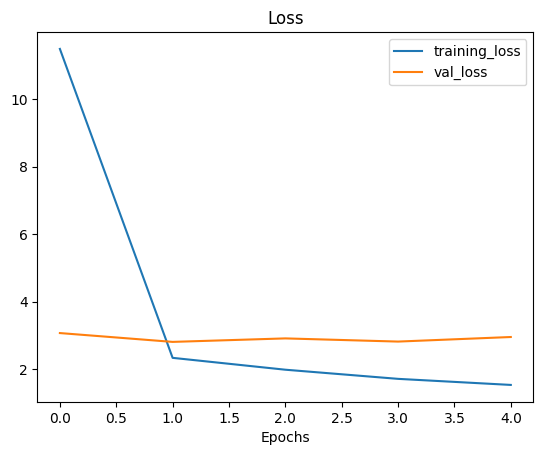

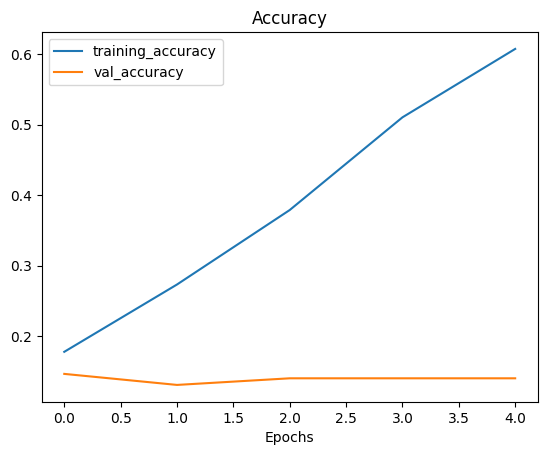

In [3]:
# Create a CNN model with L2 regularization
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10, 
                           kernel_size=3, 
                           activation="relu", 
                           input_shape=(128, 128, 3),
                           kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization added
    tf.keras.layers.Conv2D(10, 3, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(10, 3, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Conv2D(10, 3, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation="softmax", kernel_regularizer=regularizers.l2(0.01))  # L2 regularization added
])

# Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.0001,  # Relax the delta for minimal improvement
    restore_best_weights=True,
    verbose=1  # Logs when EarlyStopping is triggered
)


# Fit the model
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

# Evaluate model performance
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_accuracy:.2f}, Validation Loss: {val_loss:.2f}")

# Plot loss and accuracy curves
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

plot_loss_curves(history)

This model showed good learning rate dor training dataset but overfit and couldn't predict the unseen data on val_Dataset. So I went on creating another model with less layers trying to see if the model was too complex. 

Found 1600 files belonging to 6 classes.
Using 1280 files for training.
Found 1600 files belonging to 6 classes.
Using 320 files for validation.
Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.1728 - loss: 250.5677 - val_accuracy: 0.1750 - val_loss: 4.3975
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.2152 - loss: 2.7577 - val_accuracy: 0.1844 - val_loss: 3.4982
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.2906 - loss: 1.7306 - val_accuracy: 0.1719 - val_loss: 3.4422
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.3270 - loss: 1.5081 - val_accuracy: 0.1750 - val_loss: 3.5590
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.3666 - loss: 1.4318 - val_accuracy: 0.1719 - val_loss: 3.6066


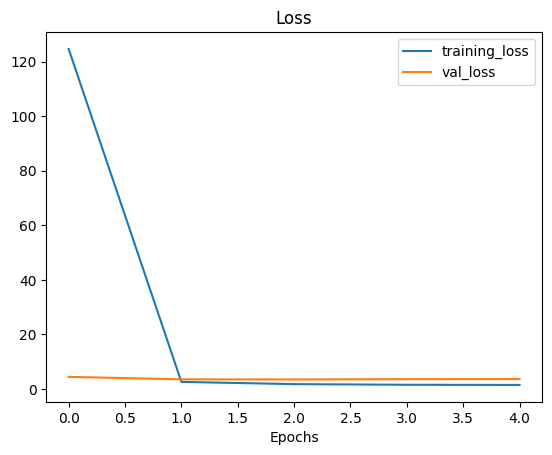

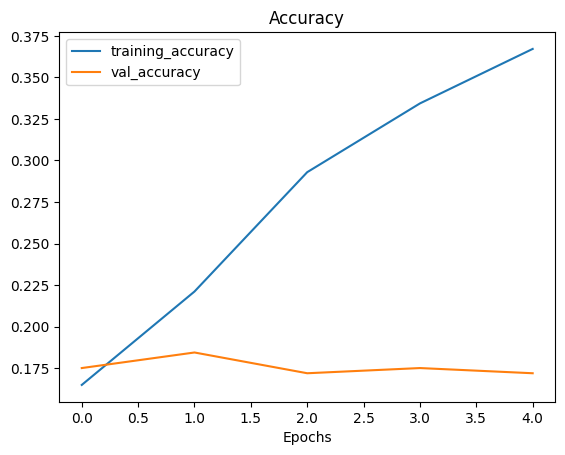

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt

# Paths to data directories
train_dir = '/kaggle/input/math482-2024-2025-1-hw-05/train/train'  # Update with your train directory path
test_dir = '/kaggle/input/math482-2024-2025-1-hw-05/test/test'    # Update with your test directory path

# Load training and validation datasets from directories
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(128, 128),
    batch_size=32,
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=42
)

val_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(128, 128),
    batch_size=32,
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=42
)

# Define the model architecture
model_2 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(128, 128, 3)),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(6, activation='softmax')  # Output layer matches the number of classes
])

# Compile the model
model_2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# Fit the model using the data
history_2 = model_2.fit(
    train_dataset,  # Use augmented data
    epochs=5,
    validation_data=val_dataset
)

# Plot loss and accuracy curves
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

plot_loss_curves(history_2)


After experimenting with all the hyperparameters of the sequential CNN, I realized that the validation accuracy fell with even the slightest regularization attempt ( L2 regularization, data augmentation) and when I didn’t use regularization it just overfit into the train data and showed low accuracy on the test data. I switced my model to residual network, predicting higher meaningful learning rate. But the residual network put too much oveload to the RAM and didn't help with the accuracy so I excluded it from my notebook.

I used data augmentation to increase the variety in my data and let the model train on a larger set of images. Larger values of the hyperparameters gave underfitting, since our data is shapes on a square background which has a quite simple structure and if changed further, can create meaningless images for the learning process. So I choose each hyperparameter in the data augmentation process rather small and tried to find balance between the L2 regularization and Data augmentation so that the model doesn't overfit.

With the show_augmented_images function I ensured that the augmented images are not too distorted and is well defined for training. 

I also added lr schedular to find the best version of the learning rate, increasing the efficiency. 

With the early stopping function, I added 40 epochs to see how the training proceeds.

Found 1600 files belonging to 6 classes.
Using 1280 files for training.
Found 1600 files belonging to 6 classes.
Using 320 files for validation.
Epoch 1/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 406ms/step - accuracy: 0.1786 - loss: 15.2278 - val_accuracy: 0.1594 - val_loss: 4.3548
Epoch 2/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 386ms/step - accuracy: 0.1578 - loss: 3.2826 - val_accuracy: 0.2062 - val_loss: 3.6161
Epoch 3/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 407ms/step - accuracy: 0.1819 - loss: 3.0451 - val_accuracy: 0.2062 - val_loss: 3.3192
Epoch 4/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 386ms/step - accuracy: 0.1606 - loss: 2.9652 - val_accuracy: 0.2156 - val_loss: 3.1590
Epoch 5/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 402ms/step - accuracy: 0.1381 - loss: 2.9312 - val_accuracy: 0.1844 - val_loss: 3.0945
Epoch 6/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 389ms/step - accuracy: 0.1450 - loss: 2.8837 - val_accuracy: 0.1875 - val_loss: 3.0348
Epoch 7/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 405ms/step - accuracy: 0.1504 - loss: 

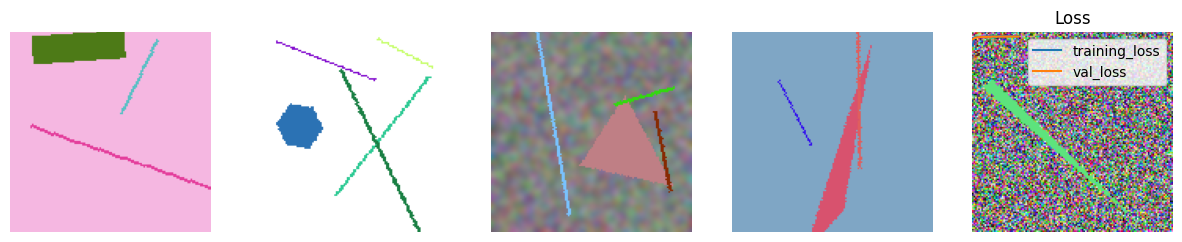

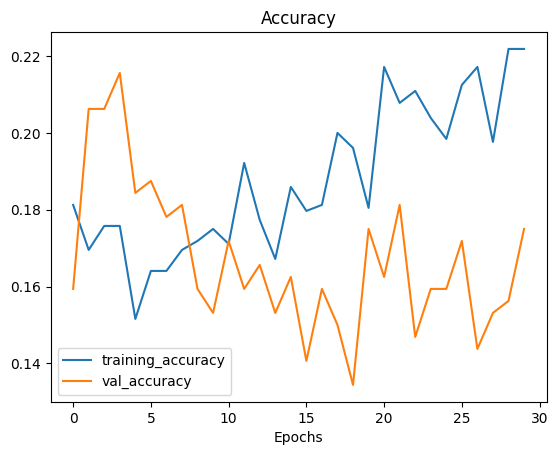

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory


# Paths to data directories
train_dir = '/kaggle/input/math482-2024-2025-1-hw-05/train/train'  # Update with your train directory path
test_dir = '/kaggle/input/math482-2024-2025-1-hw-05/test/test'    # Update with your test directory path

# Load training and validation datasets from directories
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(128, 128),
    batch_size=32,
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=42
)

val_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(128, 128),
    batch_size=32,
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=42
)



from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomContrast, RandomBrightness

def apply_data_augmentation(dataset):
    # Define data augmentation layers
    data_augmentation = tf.keras.Sequential([
        RandomFlip("horizontal"),  # Flip horizontally
        RandomRotation(0.05),  # Small rotations to avoid shifting too much
        RandomZoom(0.01),  # Reduced zoom to prevent cropping
        RandomTranslation(height_factor=0.02, width_factor=0.02),  # Small translations to avoid shifting out of view
        RandomContrast(factor=0.5),  # Random contrast to improve feature diversity
        RandomBrightness(factor=0.5)  # Random brightness adjustment for color variation
    ])
    
    # Apply augmentation to the dataset
    return dataset.map(lambda x, y: (data_augmentation(x, training=True), y))


# Function to display some augmented images
def show_augmented_images(dataset, num_images=5):
    plt.figure(figsize=(15, 15))
    for i, (image, label) in enumerate(dataset.take(1)):
        for j in range(num_images):
            ax = plt.subplot(1, num_images, j + 1)
            ax.imshow(image[j].numpy().astype("uint8"))
            ax.axis("off")
        break  # Only take the first batch

# Show a few examples from the augmented train dataset
show_augmented_images(train_dataset)


# Apply augmentation to train dataset only
train_dataset = apply_data_augmentation(train_dataset)



from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.regularizers import l2


# Create a CNN model with L2 regularization
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10, 
                           kernel_size=3, 
                           activation="relu", 
                           input_shape=(128, 128, 3),
                           kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization added
    tf.keras.layers.Conv2D(10, 3, activation="relu", kernel_regularizer=regularizers.l2(0.03)),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(10, 3, activation="relu", kernel_regularizer=regularizers.l2(0.03)),
    tf.keras.layers.Conv2D(10, 3, activation="relu", kernel_regularizer=regularizers.l2(0.03)),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation="softmax", kernel_regularizer=regularizers.l2(0.03))  # L2 regularization added
])

# Compile the model
model_3.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Compile the model
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005, decay_steps=1000, decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model_3.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.0001,  # Relax the delta for minimal improvement
    restore_best_weights=True,
    verbose=1  # Logs when EarlyStopping is triggered
)

# Add class weights to model training
history_3 = model_3.fit(
    train_dataset,
    epochs=40,
    validation_data=val_dataset,
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)
# Evaluate model performance
val_loss, val_accuracy = model_3.evaluate(val_dataset)
print(f"Validation Accuracy: {val_accuracy:.2f}, Validation Loss: {val_loss:.2f}")

# Batch the datasets
train_dataset = train_dataset.batch(32)
val_dataset = val_dataset.batch(32)


# Prefetch datasets for better performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Check the shapes of the datasets (optional)
for image_batch, label_batch in train_dataset.take(1):
    print(image_batch.shape)  # Should show (batch_size, 128, 128, 3)
    print(label_batch.shape)  # Should show (batch_size, num_classes)


# Plot loss and accuracy curves
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

plot_loss_curves(history_3)


With the data augmentation images I saw that the augmented data is indeed available for training, but even then the training accuracy got too low and the validation accuracy didn't increase. I eliminated the overfitting with the regularization techniques but even with the higher number of layers( which overfit in the first model) the learning is not meaningful. 

After trying many combinations of hyperparameters and fine tuning, I went to another path seeing that I could'nt achieve high validation accuracy, which is transfer learning. 

I used Resnet18 which is a residual network which was trained with ImageNet, I trained it again with my own training set and fine tuned it. I resized my images to 224 to work well with resnet18. With cnn learner I trained the model with my data and plotted the confusion matrix to see how well my model performs. 

Classes: ['0', '1', '2', '3', '4', '5']
Number of classes: 6


/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,2.422017,1.068894,0.612500,02:22


epoch,train_loss,valid_loss,accuracy,time
0,1.362854,0.831779,0.709375,03:22
1,1.120056,0.660295,0.750000,03:24
2,0.934676,0.500798,0.818750,03:26
3,0.745514,0.494767,0.853125,03:18
4,0.622641,0.407167,0.878125,03:20
5,0.512123,0.388666,0.846875,03:16
6,0.424585,0.396596,0.862500,03:15
7,0.361995,0.372008,0.868750,03:14
8,0.308546,0.355025,0.871875,03:17
9,0.261224,0.364048,0.868750,03:21


Submission file saved!


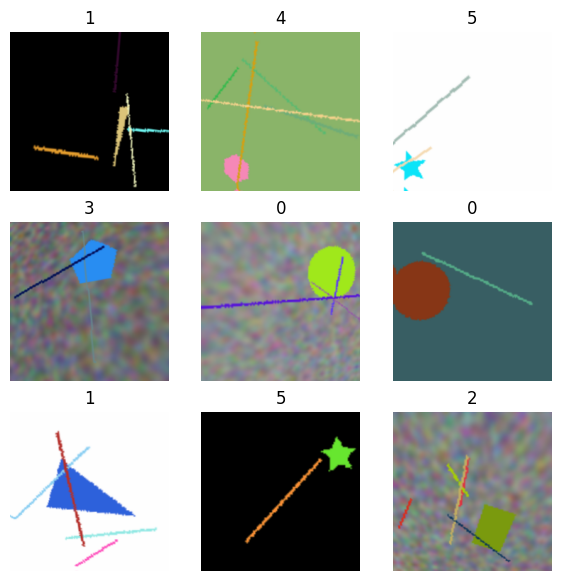

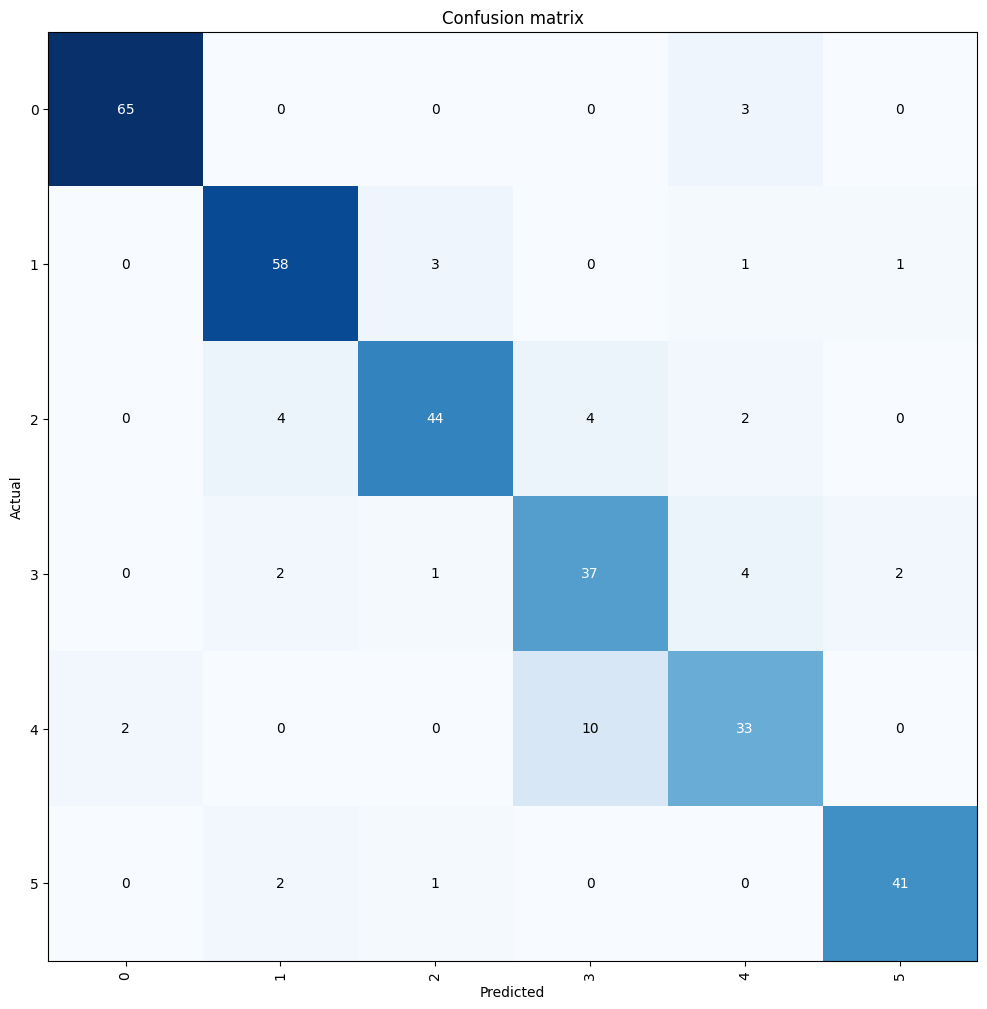

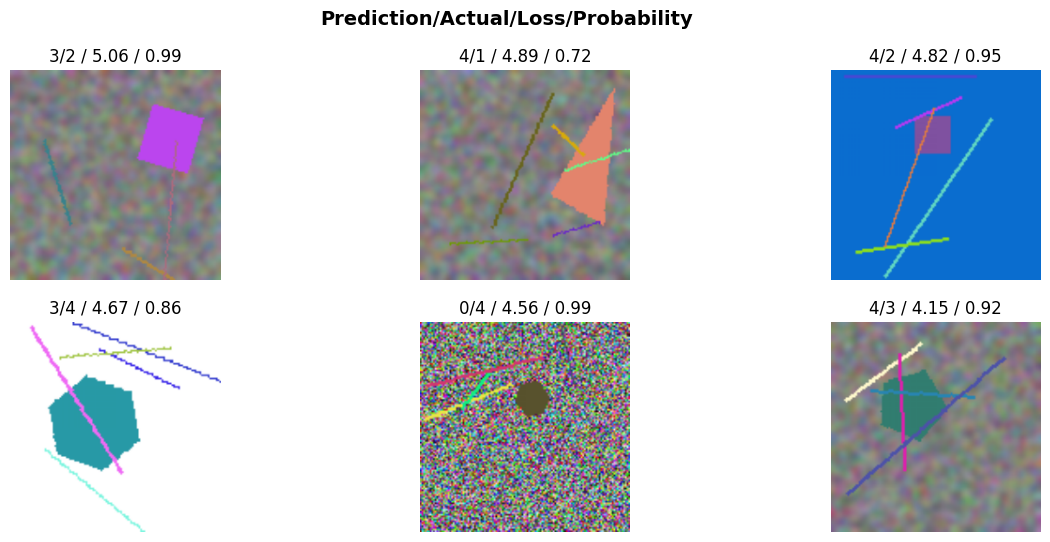

In [6]:
from fastai.vision.all import *  # Import fastai for vision tasks
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Define dataset paths
train_path = Path('/kaggle/input/math482-2024-2025-1-hw-05/train/train')
test_path = Path('/kaggle/input/math482-2024-2025-1-hw-05/test/test')  # Test data path

# Load training data
np.random.seed(40)
data = ImageDataLoaders.from_folder(
    train_path, train='.', valid_pct=0.2,
    item_tfms=Resize(224), batch_tfms=aug_transforms(),
    num_workers=0
)

# Visualize training data
data.show_batch(max_n=9, figsize=(7, 7))
print(f"Classes: {data.vocab}")
print(f"Number of classes: {len(data.vocab)}")

# Define and train the model
learn = cnn_learner(
    data, resnet18, metrics=accuracy,
    model_dir=Path('../kaggle/working')
)
learn.fine_tune(10)  # Train for 10 epochs

# Evaluate the model
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10))
interp.plot_top_losses(6, figsize=(15, 6))

# Predict test data and create a submission file
test_images = get_image_files(test_path)
test_predictions = []
for img_path in test_images:
    pred_class, _, _ = learn.predict(img_path)
    test_predictions.append((img_path.name, pred_class))

# Save predictions to a CSV
submission_df = pd.DataFrame(test_predictions, columns=["filename", "class_id"])
submission_df.to_csv('/kaggle/working/submission.csv', index=False)
print("Submission file saved!")

# Results Interpretation

In my first model the training accuracy increased but the validation accuracy didn't which indicated overfitting.
Then I reduced the complexity of my model to see if it reduces overfitting but it still showed overfitting but this time without a significant learning rate. So, in my third model I used data augmentation and l2 regularization, this time my model underfitted and couldn't learn meaningful information. 

As the histogram and the accuracy values show, the last CNN model gives the best predictions compared to my self built CNN models. Using its training on larger data the resnet structure works well with our dataset. So I choose this as my final model. 

# Conclusion

In this project I worked on several Cnn models to predict the classes of the images on our test dataset. For this goal, I used several techniques such as data preprocessing, data augmentation, L2 regularization, sequential CNN building (in which I worked with hyperparameters as relu and leakyrelu activations, adam optimizer/ learning rate, layers and filter sizes, batch normalization and Flatten). I used plots and confusion matrix to visualize what I am working with and looked at my augmented images to see if they are distorted or not. After many trials on fine tuning I concluded with using transfer learning which gave the most precise results. 